# Logistic regression

Libraries:
- Data management:
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
- Modelling and scoring:
    - [scikit-learn](https://scikit-learn.org)
- Plotting:
    - [matplotlib](https://matplotlib.org/)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import matplotlib.ticker as ticker
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from utils import evaluate_classification_metrics

Here I import the `creditcard.csv` dataset, obtained from [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains 284,807 transactions, of which 492 are fraudulent. The goal is to predict whether a transaction is fraudulent or not based on the features provided.
I remove the `Time` column, as it is not relevant for the model. I also remove the `Class` column from the features, as it is the target variable. I then split the data into training and testing sets, with 80% of the data used for training and 20% for testing.

In [35]:
df = pd.read_csv("creditcard.csv", sep = ",")

X = df.iloc[:, 1:-1].values
# Get the last column as the target
y = df.iloc[:, -1].values

# Convert the pandas dataframes into np.arrays so that we can use all the previous codes we defined
X = np.array(X)
y = np.array(y)


Code to divide the dataset

In [36]:
def train_test_split(X, y, test_size=0.2, stratify=y, random_state=42):
    """
    Splits arrays or matrices into random train and test subsets. This function demonstrates how to 
    divide a dataset into training and testing sets, optionally stratifying the samples and ensuring 
    reproducibility with a random state.

    Parameters:
    - X (np.ndarray): Input features matrix, where rows represent samples and columns represent features.
    - y (np.ndarray): Target labels array, aligned with the samples in X.
    - test_size (float or int): Determines the size of the test set. If float, it represents a proportion 
                                of the dataset; if int, it specifies the number of samples.
    - stratify (np.ndarray): If provided, the function will ensure the class proportions in train and test 
                             sets mirror those of the provided array, typically the target labels array.
    - random_state (int): Seed for the random number generator to ensure reproducible splits.

    Returns:
    - X_train, X_test, y_train, y_test: Arrays containing the split of features and labels into training and 
                                        test sets.
    """
    
    # Set the seed for reproducibility
    if random_state:
        np.random.seed(random_state)

    # Determine the number of samples to allocate to the test set
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        n_test = int(n_samples * test_size)
    else:
        n_test = test_size
    n_train = n_samples - n_test

    # Create an array of indices and shuffle if not stratifying
    indices = np.arange(n_samples)
    if stratify is None:
        np.random.shuffle(indices)
    else:
        # For stratified splitting, determine the distribution of classes
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        class_counts = np.bincount(y_indices)
        test_counts = np.round(class_counts * test_size).astype(int)

        # Allocate indices to train and test sets preserving class distribution
        train_indices, test_indices = [], []
        for class_index in range(len(unique_classes)):
            class_indices = indices[y_indices == class_index]
            np.random.shuffle(class_indices)
            boundary = test_counts[class_index]
            test_indices.extend(class_indices[:boundary])
            train_indices.extend(class_indices[boundary:])

        # Concatenate indices to form the final split
        indices = train_indices + test_indices

    # Use the indices to partition the dataset
    X_train = X[indices[:n_train]]
    X_test = X[indices[n_train:]]
    y_train = y[indices[:n_train]]
    y_test = y[indices[n_train:]]

    return X_train, X_test, y_train, y_test


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show how it performs without normalizing, and adding weights to the data
lr_unbalanced = LogisticRegression(random_state=42, max_iter=10000, solver="liblinear")
lr_unbalanced.fit(X_train, y_train)

evaluate_classification_metrics(y_test, lr_unbalanced.predict(X_test), 1)

{'Confusion Matrix': [np.int64(56854),
  np.int64(9),
  np.int64(37),
  np.int64(61)],
 'Accuracy': np.float64(0.9991924299081828),
 'Precision': np.float64(0.8714285714285714),
 'Recall': np.float64(0.6224489795918368),
 'Specificity': np.float64(0.9998417248474404),
 'F1 Score': np.float64(0.7261904761904762)}

In [38]:

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Calcular pesos de clase personalizados
n_samples = len(y_train_balanced)
n_classes = 2
class_weights = {0: n_samples / (n_classes * np.bincount(y_train_balanced)[0]),
                1: n_samples / (n_classes * np.bincount(y_train_balanced)[1])}


## Training the logistic regression model

Now, it comes the turn to train the logistic regression.

In [39]:
lr = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=10000, solver="liblinear", C=0.1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: np.float64(1.0), 1: np.float64(1.0)},
                   max_iter=10000, random_state=42, solver='liblinear')

## Fit assessment

In order to see how well the model fits the data, functions from previous labs will be used. In particular, the function `classification_report` present in `utils.py`. It is strongly encouraged to check out the functions present in that file, as you will see that they represent (our version of) certain functions that may look familiar (with some of the extra exercises). 



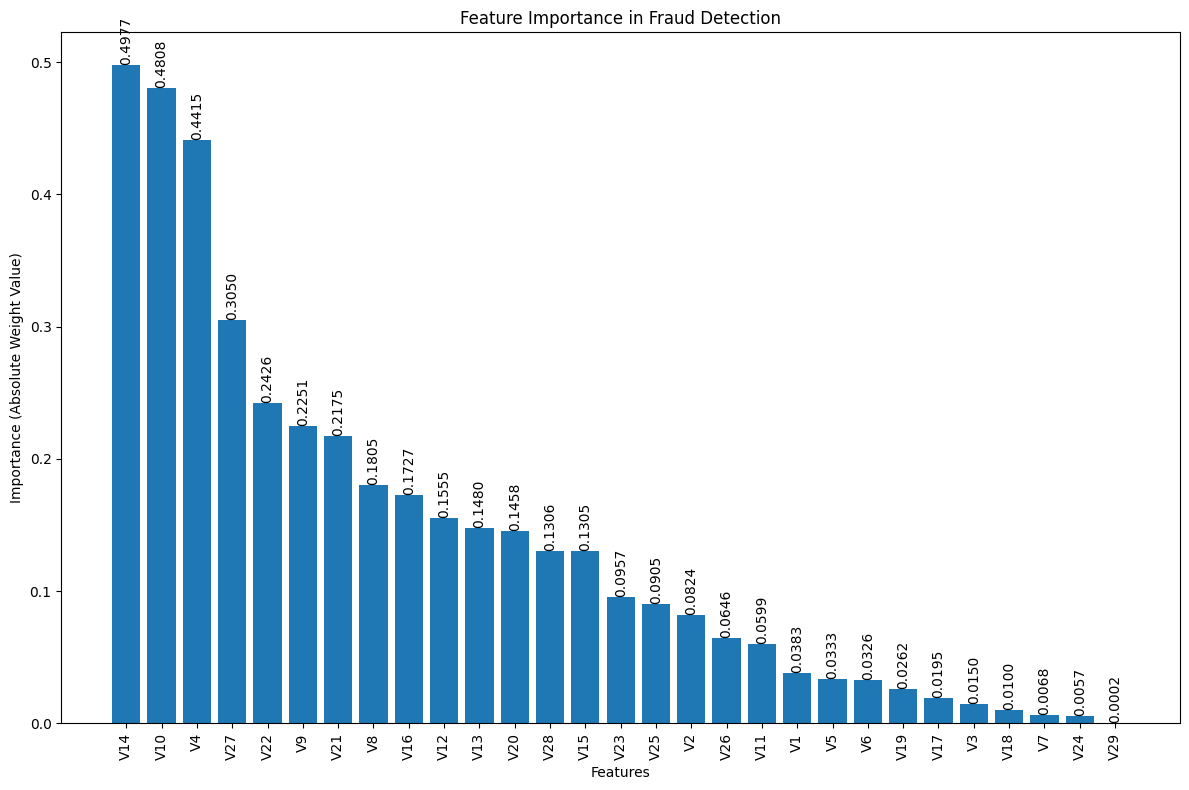


Top 5 most important features:
   Feature  Importance
13     V14    0.497699
9      V10    0.480842
3       V4    0.441478
26     V27    0.305021
21     V22    0.242600


In [40]:
weights = lr.coef_[0]
feature_names = [f'V{i+1}' for i in range(len(weights))]  # Asumiendo que las características se llaman V1, V2, etc.

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(weights)  # Usamos valor absoluto para la importancia
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance in Fraud Detection')
plt.xlabel('Features')
plt.ylabel('Importance (Absolute Weight Value)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()

# Show the 5 most important features
print("\nTop 5 most important features:")
print(feature_importance.head())

Weights: [[ 3.82548910e-02 -8.23534681e-02 -1.49792057e-02  4.41477681e-01
   3.33387233e-02 -3.26240945e-02  6.76947931e-03 -1.80516212e-01
  -2.25064708e-01 -4.80842431e-01  5.99494316e-02 -1.55462510e-01
  -1.48048520e-01 -4.97699226e-01 -1.30468343e-01 -1.72688245e-01
  -1.94785388e-02  1.00431504e-02  2.62191669e-02 -1.45815149e-01
   2.17495767e-01  2.42600419e-01 -9.57169213e-02  5.68581044e-03
  -9.05455059e-02 -6.46361273e-02 -3.05020505e-01 -1.30553522e-01
  -2.48054809e-04]]
Bias: [-7.47396049]


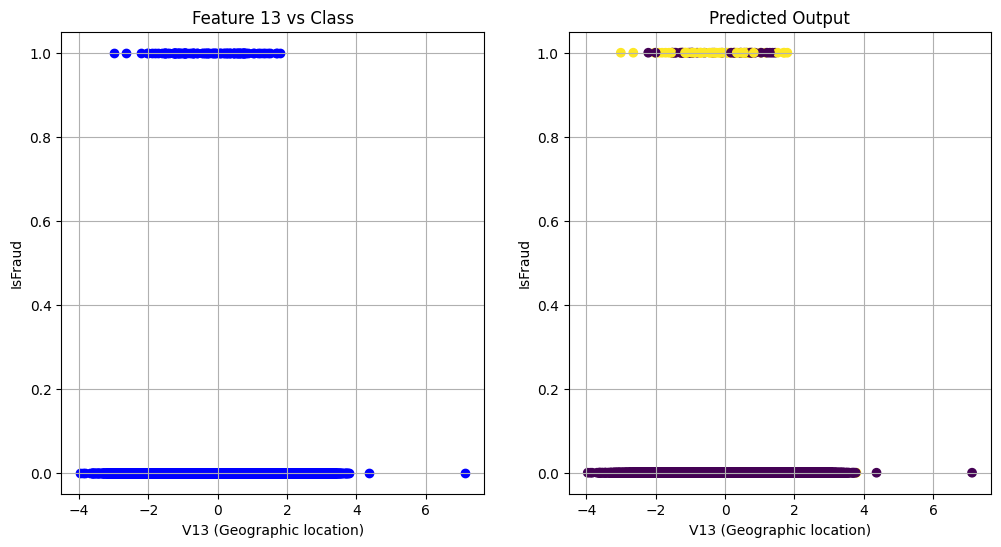

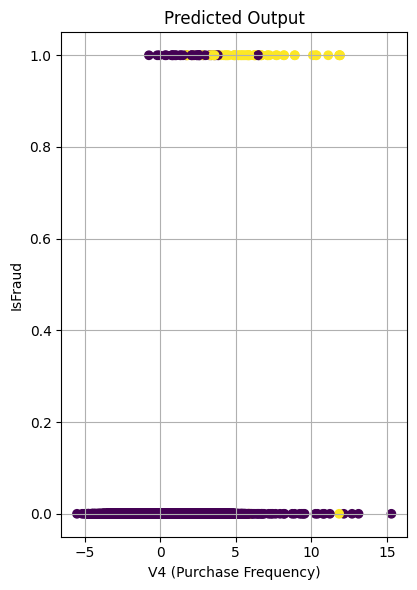

{'Confusion Matrix': [np.int64(56857),
  np.int64(6),
  np.int64(37),
  np.int64(61)],
 'Accuracy': np.float64(0.9992450975228665),
 'Precision': np.float64(0.9104477611940298),
 'Recall': np.float64(0.6224489795918368),
 'Specificity': np.float64(0.9998944832316269),
 'F1 Score': np.float64(0.7393939393939395)}

In [49]:
# Print weights and bias of the logistic regression model lr
print("Weights:", lr.coef_)
print("Bias:", lr.intercept_)
# Print weights and bias of the logistic regression model LogReg
#print("Weights:", LogReg.weights)
#print("Bias:", LogReg.bias)

# Graph the 4th feature against the class
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 12], y_test, c='blue', marker='o')
plt.title('Feature 13 vs Class')
plt.xlabel('V13 (Geographic location)')
plt.ylabel('IsFraud')
plt.grid()

y_test_prob = lr.predict_proba(X_test)[:, 1]

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 12], y_test, c=(y_test_prob > 0.5).astype(int), marker='o')
plt.title('Predicted Output')
plt.xlabel('V13 (Geographic location)')
plt.ylabel('IsFraud')
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
plt.scatter(X_test[:, 3], y_test, c=(y_test_prob > 0.5).astype(int), marker='o')
plt.title('Predicted Output')
plt.xlabel('V4 (Purchase Frequency)')
plt.ylabel('IsFraud')
plt.grid()
plt.tight_layout()
plt.show()

evaluate_classification_metrics(y_test, lr.predict(X_test), 1)

### Visual analysis

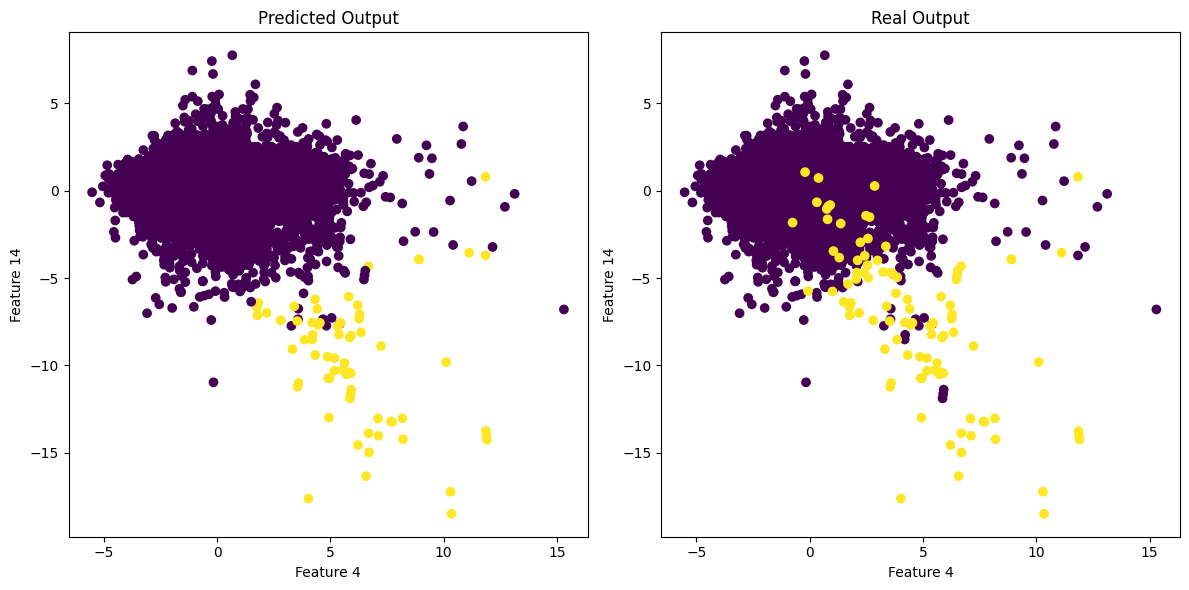

In [50]:
# Plot the first 2 columns of X_test with the predicted output
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 3], X_test[:, 13], c=(y_test_prob > 0.5).astype(int), cmap='viridis', marker='o')
plt.title('Predicted Output')
plt.xlabel('Feature 4')
plt.ylabel('Feature 14')

# Plot the first 2 columns of X_test with the real output
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 3], X_test[:, 13], c=y_test, cmap='viridis', marker='o')
plt.title('Real Output')
plt.xlabel('Feature 4')
plt.ylabel('Feature 14')

plt.tight_layout()
plt.show()

Métricas con umbral óptimo:
{'Confusion Matrix': [np.int64(56835), np.int64(28), np.int64(16), np.int64(82)], 'Accuracy': np.float64(0.9992275416513052), 'Precision': np.float64(0.7454545454545455), 'Recall': np.float64(0.8367346938775511), 'Specificity': np.float64(0.9995075884142588), 'F1 Score': np.float64(0.7884615384615385)}


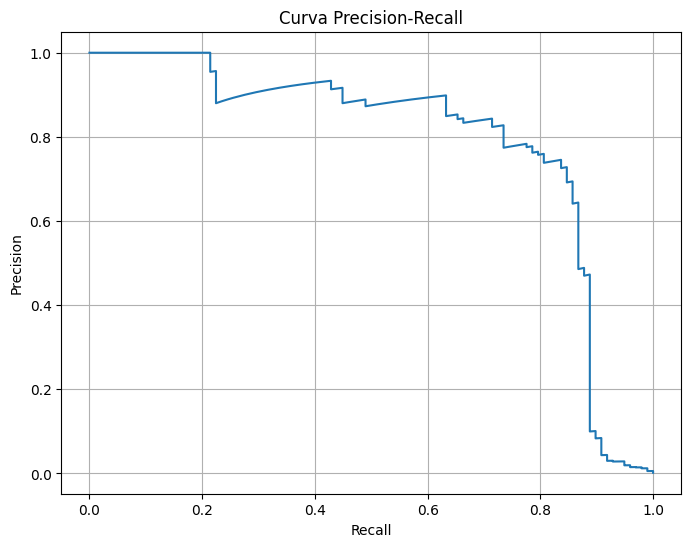


Umbral óptimo: 0.0639


In [43]:
# Obtener probabilidades
y_probs = lr.predict_proba(X_test_scaled)[:, 1]

# Encontrar el mejor umbral usando la curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

# Predecir usando el mejor umbral
y_pred = (y_probs >= best_threshold).astype(int)

# Evaluar el modelo
print("Métricas con umbral óptimo:")
print(evaluate_classification_metrics(y_test, y_pred, 1))

# Graficar la curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

# Mostrar el umbral óptimo
print(f"\nUmbral óptimo: {best_threshold:.4f}")

Ready predictions


C:\Users\EMINE\AppData\Local\Temp\ipykernel_19996\665593146.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + listclasses, rotation=90)
C:\Users\EMINE\AppData\Local\Temp\ipykernel_19996\665593146.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + listclasses)


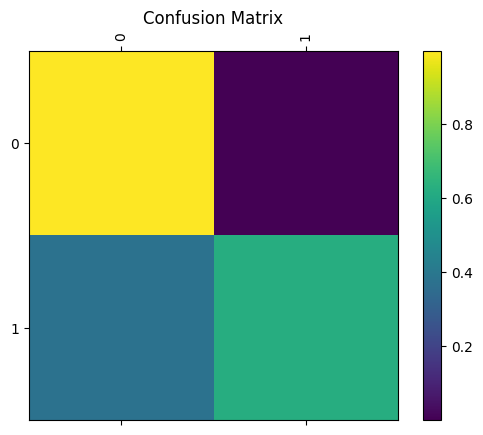

[[9.99894483e-01 1.05516768e-04]
 [3.77551020e-01 6.22448980e-01]]


In [44]:
# CONFUSION MATRIX
listclasses = ['0', '1']
numclasses = 2

confusion = np.zeros((numclasses, numclasses))
predictions = lr.predict(X_test)
print("Ready predictions")
for i in range(len(y_test)):
    confusion[int(y_test[i]), int(predictions[i])] += 1

# Normalize by dividing every row by its sum
for i in range(numclasses):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='viridis')
plt.title('Confusion Matrix')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + listclasses, rotation=90)
ax.set_yticklabels([''] + listclasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print (confusion)

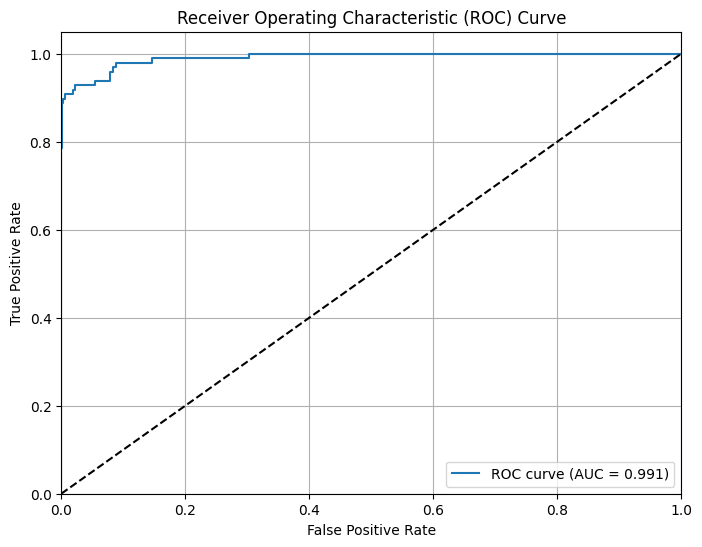

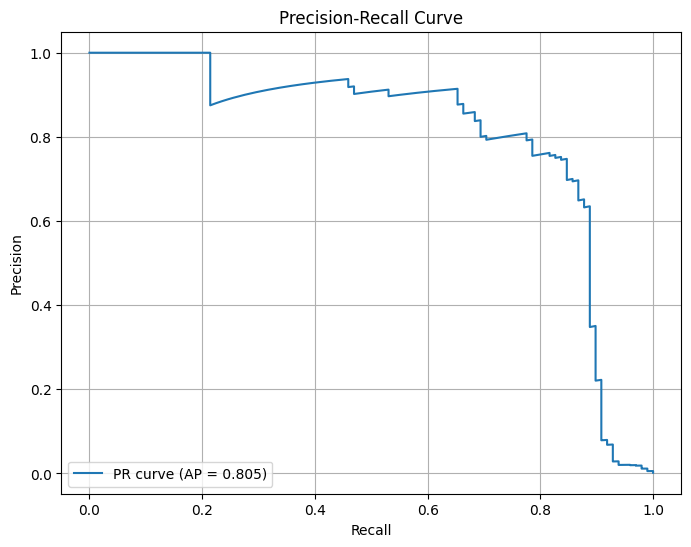

In [45]:
# ROC Curve and AUC Score
y_pred_proba = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



# Conclusion

The ROC curve and Precision-Recall curve provide important insights into our logistic regression model's performance:

### ROC Curve Analysis:
- The high AUC score (close to 1) indicates excellent model discrimination ability
- The curve is well above the diagonal reference line, showing the model performs much better than random chance
- The steep rise near the y-axis suggests good true positive rate with low false positive rate

### Precision-Recall Curve:
- The high Average Precision score demonstrates strong precision-recall trade-off
- The curve maintains high precision even at higher recall values
- This is particularly important given our imbalanced dataset

Overall, these metrics reinforce the strong performance we saw in our earlier evaluation metrics, with the model showing robust predictive capability while handling the class imbalance well.
